# Adversarial examples

V tomto cvičení si vyzkoušíme ošálit natrénovanou konvoluční síť malým pozměněním vstupního obrázku tak, aby výsledné skóre bylo maximální pro nějakou námi zvolenou třídu. Pokud např. neuronová síť správně klasifikuje obrázek automobilu s výstupní pravděpodobností 99 %, cílenou, pro lidské oko však téměř neznatelnou úpravou můžeme dosáhnout 99 % výstupní pravděpodobnosti např. pro třídu jelen.

## Import

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tqdm

from IPython.core.debugger import set_trace

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch import optim
from torchvision import transforms

USE_CUDA = torch.cuda.is_available()
USE_CUDA = False

## Data

Data tentokrát potřebovat nebudeme. Stačit nám bude jediný obrázek. Hodit se nám ale budou názvy tříd.

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Pomocné funkce

In [5]:
def numpy2torch(img):
    """
    funkce pro prevod obrazku z `numpy.nadarray` do `torch.Tensor`
    
    pozn.: vstup `img` je jediny obrazek, nikoliv batch
    """
    img = img.transpose(2, 0, 1)
    img = img.astype(np.float32) / 255.
    ten = torch.from_numpy(img[None])
    if USE_CUDA:
        ten = ten.cuda()
    return ten

In [6]:
def torch2numpy(ten):
    """
    funkce pro prevod z `torch.Tensor` do `numpy.ndarray`
    
    pozn.: vstup `ten` je tenzor jedineho obrazku, nikoliv davky
    """
    return np.uint8(255 * ten.cpu().numpy()[0].transpose(1, 2, 0))

In [7]:
def predict_and_show(test_rgb, model, resize=None):
    rgb_ = cv2.resize(test_rgb, resize, -1, 0, 0, cv2.INTER_NEAREST) if isinstance(resize, tuple) else test_rgb
    xt = Variable(numpy2torch(rgb_))
    st = model(xt).data.cpu().numpy().ravel()
    pt = np.exp(st) / np.sum(np.exp(st))
        
    plt.figure(figsize=(5, 5))
    plt.imshow(test_rgb)
    ids = np.argsort(-pt)
    for i, ci in enumerate(ids):
        plt.gcf().text(1., 0.8 - 0.075 * i, '{}: {:.2f} %'.format(classes[ci], 100. * pt[ci]), fontsize=24)
    plt.subplots_adjust()
    plt.show()

## Model

Model tentokrát budeme mít předdefinovaný. Třída je odvozená z architektury VGG, jen s méně vrstvami. Na validační sadě CIFAR-10 dosáhne 88.7 %.

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        in_chnls = 3
        layers = []
        for out_chnls in (64, 'm', 128, 'm', 256, 256, 'm', 512, 512, 'm', 512, 512, 'm'):
            if out_chnls == 'm':
                layers.append(nn.MaxPool2d(2))
            else:
                layers.append(nn.Conv2d(in_chnls, out_chnls, 3, padding=1))
                layers.append(nn.BatchNorm2d(out_chnls))
                layers.append(nn.ReLU(inplace=True))
                in_chnls = out_chnls
        layers.append(nn.AvgPool2d(1))
        self.features = nn.Sequential(*layers)
        
        self.classifier = nn.Linear(512, 10)
        
        if USE_CUDA:
            self.cuda()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [22]:
convnet = ConvNet()

Jak jsme si již ukazovali na jednom předchozích cvičení, model lze načíst funkcí `load_state_dict`. Předtrénované váhy jsou k dispozici [na této adrese](https://1drv.ms/u/s!AotVPA94wWKxv2kXJkECCawp569A).

In [23]:
state = torch.load('cifar-vgg11-32x32-ep163-val=0.887.pth')
convnet.load_state_dict(state['model'])

Jelikož model obsahuje vrstvy, které se chovají různě v trénovací a testovací fázi, nesmíme zapomenout přepnout model do testovacího režimu. Jinak může být výstup často nesmyslný, což si ostatně můžete vyzkoušet sami.

In [24]:
convnet.eval();

Model navíc nebudeme učit a pro zrychlení výpočtu úplně zablokujeme výpočet gradientů na jeho parametry. Síť zde vystupuje jako sice diferencovatelná, ale jinak neměnná funkce.

In [25]:
for par in convnet.parameters():
    par.detach_()

## Adversarial examples

Načteme nějaký testovací obrázek, např. naši oblíbenou žabičku.

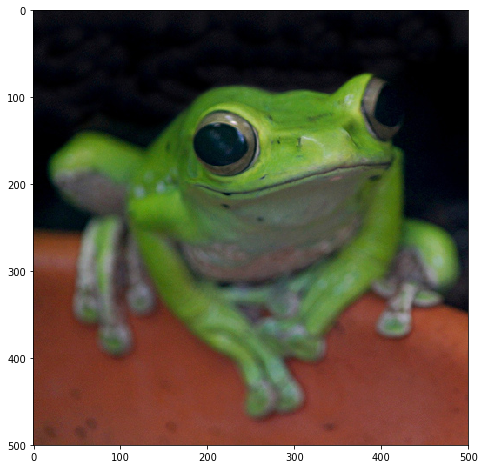

In [26]:
url = 'http://farm5.staticflickr.com/4070/4717363945_b73afd78a9.jpg'
test_rgb = io.imread(url)

plt.imshow(test_rgb)
plt.show()

Vyzkoušíme, zdali síť funguje.

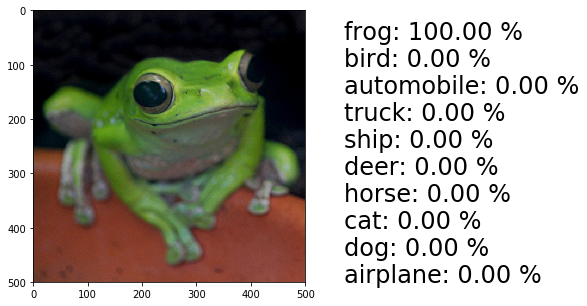

In [27]:
predict_and_show(test_rgb, convnet, resize=(32, 32))

Síť je ovšem předtrénovaná na CIFAR10, což znamená, že na vstupu očekává RGB obrázky o rozměrech 32x32 pixelů. Jelikož budeme potřebovat gradient na vstupní obrázek, bude snazší pracovat s touto velikostí. Ve druhé části cvičení pak toto omezení odstraníte.

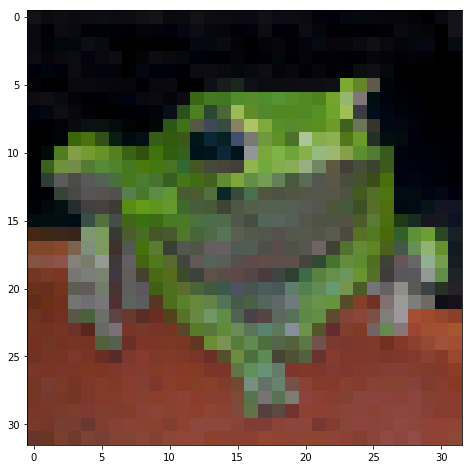

In [28]:
test_rgb_small = cv2.resize(test_rgb, (32, 32))

plt.imshow(test_rgb_small)
plt.show()

Jak bylo zmíněno, na rozdíl od učení modelu pro klasifikaci tentokrát nebudeme pro dosažení kýženého výstupu upravovat parametry, ale samotný vstup. Kromě tohoto rozdíl ale jinak princip zůstává stejný, tj. použijeme nějakou z gradientních metod pro minimalizaci funkce. Jelikož nás tedy bude zajímat gradient na vstup, musíme do konstruktoru třídy `Variable` přidat volitelný parametr `requires_grad=True`.

In [29]:
adv_input = Variable(numpy2torch(test_rgb_small), requires_grad=True)

Podívejme se na vektor výstupních pravděpodobností.

In [30]:
softmax = nn.Softmax(dim=1)

In [31]:
scores = convnet(adv_input)
print(softmax(scores), scores, classes)

print(adv_input)

Variable containing:

Columns 0 to 5 
 4.4583e-08  1.1156e-05  3.1001e-05  2.7109e-06  8.4343e-07  2.3904e-08

Columns 6 to 9 
 9.9995e-01  1.0414e-07  2.6000e-07  4.0083e-06
[torch.FloatTensor of size 1x10]
 Variable containing:

Columns 0 to 7 
 -4.3707   1.1517   2.1738  -0.2630  -1.4305  -4.9939  12.5552  -3.5222

Columns 8 to 9 
 -2.6073   0.1281
[torch.FloatTensor of size 1x10]
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Variable containing:
(0 ,0 ,.,.) = 
  0.0745  0.0431  0.0588  ...   0.0000  0.0314  0.0706
  0.0314  0.0000  0.0510  ...   0.0196  0.0000  0.0784
  0.0392  0.0039  0.0039  ...   0.0196  0.0000  0.0196
           ...             ⋱             ...          
  0.4745  0.4667  0.4667  ...   0.5294  0.5176  0.5333
  0.4627  0.4549  0.4627  ...   0.5608  0.5686  0.5569
  0.3922  0.4078  0.4745  ...   0.5529  0.5608  0.5569

(0 ,1 ,.,.) = 
  0.0667  0.0392  0.0471  ...   0.0039  0.0314  0.0784
  0.0353  0.0000  0.0431  ...

### Zadání

Upravte `adv_input` tak, aby obrázek byl s alespoň 99% pravděpodobností klasifikován jako jelen (deer). Adversarial obrázek  přitom musí zůstat vizuálně téměř nerozeznatelný od původního.

**Postup:**
- síti je třeba nějak sdělit, že na obrázku není žába, ale jelen
- možností je více:
  - standardní cross entropy loss, kdy správná třída $y$ je nastavena na `classes.index('deer')`
  - bez lossu, kdy zpětný průchod začne až od výstupního skóre (každá proměnná (`Variable`) v PyTorch má metodu `backward`), přičemž gradient shora je nastaven na vektor $[-1, -1, \ldots, +1, \ldots, -1]$; tento postup je častější a bude fungovat lépe
- vypočteným gradientem updatujte vstup
  - buď ručně - každá proměnná vytvořená s `requires_grad=True` po zavolání `backward` obsahuje `grad` (pokud tato proměnná je součástí dynamického výpočetního grafu),
  - nebo skrze PyTorch optimizer jako při trénování sítě
- úprava je podobný proces jako trénování sítě, tj. opakujeme uvedené kroky, dokud výstupní pravděpodobnost pro třídu `deer` není alespoň 99 %
- *pozn*: během optimalizace je důležité, aby hodnoty obrázku zůstávaly v předepsaných mezích, tj. v intervalu $[0, 1]$

Výsledek zapište do proměnné `adv_rgb` typu `numpy.ndarray`, tj. jako standardní numpy obrázek, o stejných rozměrech a datovém typu jako `test_rgb`.

In [32]:
def train_adv(model, optimizer, image, fake_class, size=False):
    if size:
        x = F.adaptive_avg_pool2d(image,(32,32))
    else:
        x = image
    y = -1 * torch.ones(10)
    y[fake_class] = 1
   
    y = Variable(y[None])
        
    # dopredny pruchod
    optimizer.zero_grad()
    score = model(x)
    score.backward(-y)
        
    # update parametru
    optimizer.step()

In [34]:
optimizer = optim.Adam([adv_input],lr = 0.005, weight_decay = 0.02)

In [35]:
maxEp = 200
f_class = 'deer'
for ep in range(maxEp):
    train_adv(convnet, optimizer, adv_input, classes.index(f_class))
    adv_input.data = torch.clamp(adv_input.data, 0, 1) # from 0 to 1
    score = convnet(adv_input)
    prob = softmax(score)
    if prob.data[0][classes.index(f_class)] >= 0.99:
        print("done: ", prob.data[0][classes.index(f_class)])
        break;
    print(prob.data[0][classes.index(f_class)]) 

0.0008606140036135912
0.41046223044395447
done:  0.9955827593803406


In [ ]:
...

In [36]:
adv_rgb_small = torch2numpy(adv_input.data)

Predikce na původním, nezměněném obrázku:

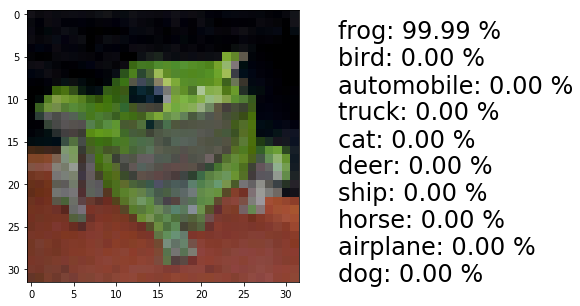

In [37]:
predict_and_show(test_rgb_small, convnet)

Predikce na adversarial obrázku:

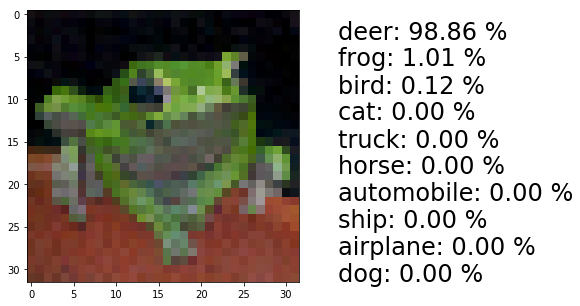

In [38]:
predict_and_show(adv_rgb_small, convnet)

Původní, adversarial a jejich rozdíl vedle sebe:

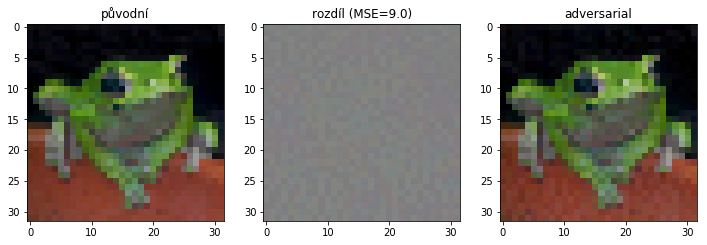

In [39]:
plt.subplot(1, 3, 1)
plt.imshow(test_rgb_small)
plt.title('původní')
plt.subplot(1, 3, 2)
dif = test_rgb_small.astype(np.float) - adv_rgb_small.astype(np.float)
plt.imshow(np.uint8(128 + dif))
mse = np.mean(dif ** 2.)
plt.title('rozdíl (MSE={:.1f})'.format(mse))
plt.subplot(1, 3, 3)
plt.title('adversarial')
plt.imshow(adv_rgb_small)
plt.show()

## Původní rozlišení

Adversarial lze vytvořit i v původním rozlišení, bez transformace na velikost 32x32 pixelů. Jediné, co k tomu potřebujeme, je nahradit funkci `cv2.resize` diferencovatelnou operací takovou, pro kterou funguje PyTorch autograd pro automatický výpočet gradientu na vstup (backprop). Prohledejte dokumentaci, najděte vhodnou funkci a zopakujte předchozí postup na obrázek v původním rozlišení.

Nápověda: stačí jeden řádek navíc ;-)

In [41]:
adv_input2 = Variable(numpy2torch(test_rgb), requires_grad=True)

In [42]:
optimizer = optim.Adam([adv_input2],lr = 0.0008, weight_decay = 0.02)

In [43]:
maxEp = 200
f_class = 'deer'
for ep in range(maxEp):
    train_adv(convnet, optimizer, adv_input2, classes.index(f_class), size=True)
    adv_input2.data = torch.clamp(adv_input2.data, 0, 1) # from 0 to 1
    resized = rgb_ = cv2.resize(torch2numpy(adv_input2.data), (32,32), -1, 0, 0, cv2.INTER_NEAREST)
    xt = Variable(numpy2torch(rgb_))
    score = convnet(xt)
    prob = softmax(score)
    if prob.data[0][classes.index(f_class)] >= 0.99:
        print("done: ", prob.data[0][classes.index(f_class)])
        break;
    print(prob.data[0][classes.index(f_class)]) 

3.877160636989174e-08
3.877160636989174e-08
3.9660921657969084e-08
3.9396514495138035e-08
9.333093231589373e-08
9.443430570854616e-08
9.692909230807345e-08
1.0207352829638694e-07
1.0254733950887385e-07
2.2292329049378168e-07
2.5138805881397275e-07
2.5827981176007597e-07
2.675294012988161e-07
2.7872718533217267e-07
6.310498861239466e-07
7.496990974686923e-07
7.997161333150871e-07
8.362587209376215e-07
9.61858290793316e-07
2.247579686809331e-06
2.7966043489868753e-06
3.027950469913776e-06
3.1868125915934797e-06
4.896658083453076e-06
9.338988093077205e-06
1.0814962479344103e-05
1.249169963557506e-05
1.4425074368773494e-05
2.5284947696491145e-05
3.83027181669604e-05
4.669289046432823e-05
5.6563356338301674e-05
7.932542212074623e-05
0.0001170984614873305
0.00018625326629262418
0.00024882276193238795
0.0003650604921858758
0.0005024169804528356
0.0007067248225212097
0.0009997596498578787
0.001630014623515308
0.0025158566422760487
0.0035701279994100332
0.004611012525856495
0.007348828949034214

In [48]:
adv_rgb = torch2numpy(adv_input2.data)

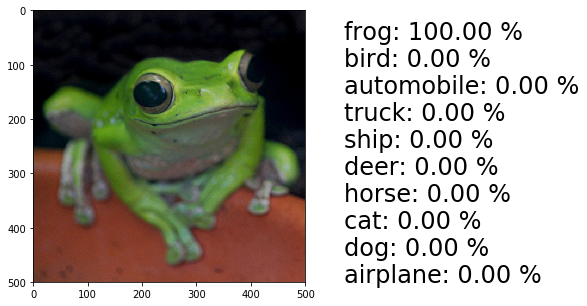

In [49]:
predict_and_show(test_rgb, convnet, resize=(32, 32))

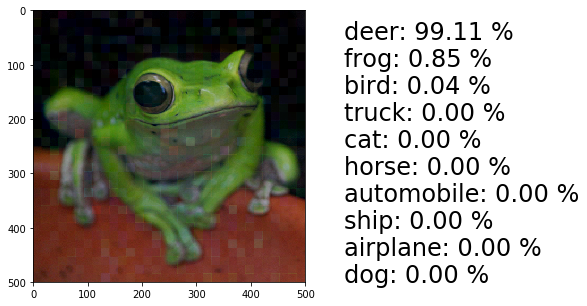

In [50]:
predict_and_show(adv_rgb, convnet, resize=(32, 32))

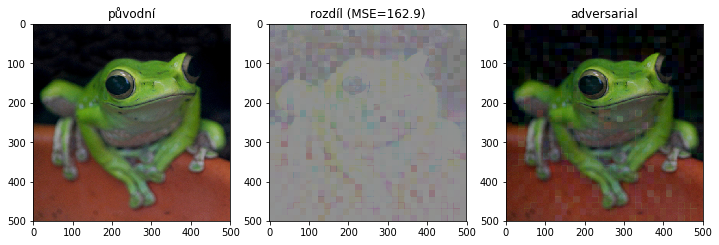

In [51]:
plt.subplot(1, 3, 1)
plt.imshow(test_rgb)
plt.title('původní')
plt.subplot(1, 3, 2)
dif = test_rgb.astype(np.float) - adv_rgb.astype(np.float)
plt.imshow(np.uint8(128 + dif))
mse = np.mean(dif ** 2.)
plt.title('rozdíl (MSE={:.1f})'.format(mse))
plt.subplot(1, 3, 3)
plt.title('adversarial')
plt.imshow(adv_rgb)
plt.show()